# Healthcare Marketing Analytics Project
## Determining the impact of R&D Ration on Healthcare Firms' Value

In [215]:
#General Operations Libraries
import pickle
import warnings

#Data Analysis Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#Data Preparation, Modeling, and Evaluation (SKLearn Modules)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.decomposition import PCA

warnings.filterwarnings(action="ignore")
%matplotlib inline

### Data Sourcing
This dataset was provided by Bocconi University, Marketing Analytics department. Here is the description of the data columns in the dataset:
- Firm ID (variable name: id)
- Year (variable name: year)
- Firm Total Assets (unit: million $) (variable name: assets)
- Long-term Debt (unit: million $) (variable name: debt)
- Earnings (unit: million $): This variable is EBITA (earnings before interest, taxes, depreciation,
and amortization). (variable name: earnings)
- Cash Flows (unit: million $): This is Net Cash Flow from Operating Activity. However, please
conceptually consider this variable a proxy for profit based on only cash as some academic
studies do. (variable name: cashflow)
- Sales (unit: million $) (variable name: sales)
- Advertising Expenditure (unit: million $): Conceptually, you can consider this variable as a firm’s
brand building effort. (variable name: ad)
- R&D Expenditure (unit: million $): Conceptually, you can consider this variable as a firm’s
innovation effort. (variable name: rd)
- Marketing, Selling, and Operating Expenditure (unit: million $): Conceptually, you can consider
this variable as a firm’s selling and marketing effort (e.g., sale forces, customer management)
except advertising. Note that this variable does not include advertising expenditure and R&D
expenditure. (variable name: mkt)
- Product Market Threat: Consider this variable as competitive threats that a firm goes through in
its product markets. Higher values indicate higher levels of competitive threats. (variable name:
threat)
- 2001 Recession (dummy): 1 if the observation is in the year of 2001 recession and 0 otherwise.
(variable name: rec1)
- 2008 Recession (dummy): 1 if the observation is in the year of 2008 recession and 0 otherwise.
(variable name: rec2)
- Firm Value (i.e., Tobin’s Q) (variable name: fv)
- Market Valuation (unit: million $): Market value of a firm (variable name: mv)
- Business sector where a firm operates (indicator) (variable name: sector)
    - 1: Manufacturing (Consumer Durables and Non-Durables) e.g., Food, Tobacco, Textile, Apparel, Toys, Cars, TVs, Furniture, Appliances
    - 2: Manufacturing (Non-Consumer Goods) e.g., Machinery, Office Furniture, Paper, Computers, Electronic Equipment
    - 3: Wholesale
    - 4: Retailing
    - 5: Healthcare e.g., healthcare, medical equipment, drugs
    - 6: Information Technology e.g., software publishers, telecommunications, web search portals
    - 7: Service Sector (Technical Services, Professional and Administrative Services, and Education Services)
    - 8: Entertainment, Accommodation, and Full Service Restaurants

In [217]:
all_data = pd.read_csv('marketing_insight.csv')
all_data.head()

,id,year,assets,debt,earnings,cashflow,sales,mv,ad,rd,threat,fv,rec1,rec2,mkt,sector
0,42,1993,4.103,0.000,-1.748,-2.175,3.610,63.674000,0.074,0.305,1.7482,14.836461,0,0,2.042,5
1,2607,1993,18.897,0.716,-2.458,-2.016,26.274,10.802283,0.748,1.310,18.0228,0.083362,0,0,5.405,1
2,1204,1993,37.476,23.735,4.359,-0.087,63.938,29.856251,0.759,0.542,1.0184,1.225564,0,0,9.997,3
3,899,1993,7.882,0.011,-4.933,-4.958,5.411,58.403999,0.775,2.059,9.1024,6.930602,0,0,6.089,5
4,1746,1993,24.496,0.000,7.723,-5.843,43.030,208.065000,0.719,0.372,1.0658,7.952849,0,0,9.994,5


In [218]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22723 entries, 0 to 22722
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        22723 non-null  int64  
 1   year      22723 non-null  int64  
 2   assets    22723 non-null  float64
 3   debt      22723 non-null  float64
 4   earnings  22723 non-null  float64
 5   cashflow  22723 non-null  float64
 6   sales     22723 non-null  float64
 7   mv        22723 non-null  float64
 8   ad        22723 non-null  float64
 9   rd        22723 non-null  float64
 10  threat    22723 non-null  float64
 11  fv        22723 non-null  float64
 12  rec1      22723 non-null  int64  
 13  rec2      22723 non-null  int64  
 14  mkt       22723 non-null  float64
 15  sector    22723 non-null  int64  
dtypes: float64(11), int64(5)
memory usage: 2.8 MB


#### Filtering out the Healthcare Sector
This project will be focused on the Healthcare sector, therefore, we'll filter out other sectors to remain with **sector 5** – ***Healthcare***.

In [219]:
data = all_data[all_data['sector']==5] #Filtering out all sectors to remain with healthcare data
data = data.drop(['sector'], axis=1) #Delete the sector column as it is no longer relevant
data.head()

,id,year,assets,debt,earnings,cashflow,sales,mv,ad,rd,threat,fv,rec1,rec2,mkt
0,42,1993,4.103,0.000,-1.748,-2.175,3.610,63.674000,0.074,0.305,1.7482,14.836461,0,0,2.042
3,899,1993,7.882,0.011,-4.933,-4.958,5.411,58.403999,0.775,2.059,9.1024,6.930602,0,0,6.089
4,1746,1993,24.496,0.000,7.723,-5.843,43.030,208.065000,0.719,0.372,1.0658,7.952849,0,0,9.994
10,1312,1993,10.248,0.000,-15.562,-9.349,0.000,23.978001,0.000,4.075,5.0967,2.646077,0,0,11.487
19,1686,1993,6.007,0.929,1.055,0.483,6.980,19.942678,0.086,0.197,1.0549,3.027747,0,0,1.558


In [220]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3292 entries, 0 to 22569
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        3292 non-null   int64  
 1   year      3292 non-null   int64  
 2   assets    3292 non-null   float64
 3   debt      3292 non-null   float64
 4   earnings  3292 non-null   float64
 5   cashflow  3292 non-null   float64
 6   sales     3292 non-null   float64
 7   mv        3292 non-null   float64
 8   ad        3292 non-null   float64
 9   rd        3292 non-null   float64
 10  threat    3292 non-null   float64
 11  fv        3292 non-null   float64
 12  rec1      3292 non-null   int64  
 13  rec2      3292 non-null   int64  
 14  mkt       3292 non-null   float64
dtypes: float64(11), int64(4)
memory usage: 411.5 KB


After filtering the data to remain with entries in the Healthcare industry, we remain with 3292 entries. There's no missing data in the dataset as all columns are non-null. Now, let us drop all duplicate entries before we output a data summary.

In [222]:
#Drop duplicate entries
data = data.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3292 entries, 0 to 22569
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        3292 non-null   int64  
 1   year      3292 non-null   int64  
 2   assets    3292 non-null   float64
 3   debt      3292 non-null   float64
 4   earnings  3292 non-null   float64
 5   cashflow  3292 non-null   float64
 6   sales     3292 non-null   float64
 7   mv        3292 non-null   float64
 8   ad        3292 non-null   float64
 9   rd        3292 non-null   float64
 10  threat    3292 non-null   float64
 11  fv        3292 non-null   float64
 12  rec1      3292 non-null   int64  
 13  rec2      3292 non-null   int64  
 14  mkt       3292 non-null   float64
dtypes: float64(11), int64(4)
memory usage: 411.5 KB


It seems there are no duplicate entries as the entries remain 3292 even after drop all duplicates.

In [223]:
data.describe()

,id,year,assets,debt,earnings,cashflow,sales,mv,ad,rd,threat,fv,rec1,rec2,mkt
count,3292.000000,3292.000000,3292.000000,3292.000000,3292.000000,3292.000000,3292.000000,3292.000000,3292.000000,3292.000000,3292.000000,3292.000000,3292.000000,3292.000000,3292.000000
mean,1724.311665,2007.315614,3429.609149,775.250014,563.978191,418.321345,1706.000846,6780.085848,71.307075,255.238051,8.154948,2.360336,0.034933,0.045261,408.670110
std,1058.535967,7.179453,16334.438091,3832.730215,2663.596820,2038.262931,7211.308404,29286.544040,354.174284,1154.296713,11.103680,2.746864,0.183638,0.207908,1715.608140
min,1.000000,1993.000000,0.404000,0.000000,-666.676000,-635.442000,0.000000,0.809150,0.000000,0.000000,1.000000,-0.586277,0.000000,0.000000,-1895.591100
25%,774.000000,2002.000000,34.815250,0.000000,-5.244250,-4.947750,26.508250,52.787131,0.288000,1.748750,1.294500,0.861938,0.000000,0.000000,12.847250
50%,1584.000000,2007.000000,109.109000,1.957500,4.940000,3.104500,84.768000,207.849600,1.103000,6.816000,3.197450,1.604317,0.000000,0.000000,34.998501
75%,2629.000000,2013.000000,495.226000,65.151500,58.128250,39.787500,354.252500,1014.843800,6.500000,30.600500,10.694725,2.901638,0.000000,0.000000,119.889250
max,3523.000000,2019.000000,212949.000000,63226.000000,28795.000000,23416.000000,82059.000000,384003.780000,4000.000000,12245.000000,85.363701,45.089115,1.000000,1.000000,19088.000000


### Generating Additional Variables
Here are varaiables we are generating:

- **R&D Ratio (rd_ratio):** R&D Expenditure/Sales
- **Strategic Emphasis (se):** (Advertising Expenditure - R&D Expenditure)/Firm Total Assets
- **Log Assets:** Logarithm of Firm Total Assets
- **Market Share:** Company's sales in Year X/Gross industry sales in Year X
- **Market Growth:** Percentage growth in sales from year to year (This is Year specific and not company specific)

**Note:** We'll drop instances where Sales and Assets is equal to 0 first, as this will output infinite values for RD_RATIO, AD_RATIO and SE. However, we are positive from the data summary that there are no firms with Assets as 0 (min value was 0.404000)

In [224]:
data = data[data['sales'] > 0] #Drop Instances where Sales is equal to 0
data = data[data['assets'] > 0] #Drop Instances where Assets is equal to 0
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3279 entries, 0 to 22569
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        3279 non-null   int64  
 1   year      3279 non-null   int64  
 2   assets    3279 non-null   float64
 3   debt      3279 non-null   float64
 4   earnings  3279 non-null   float64
 5   cashflow  3279 non-null   float64
 6   sales     3279 non-null   float64
 7   mv        3279 non-null   float64
 8   ad        3279 non-null   float64
 9   rd        3279 non-null   float64
 10  threat    3279 non-null   float64
 11  fv        3279 non-null   float64
 12  rec1      3279 non-null   int64  
 13  rec2      3279 non-null   int64  
 14  mkt       3279 non-null   float64
dtypes: float64(11), int64(4)
memory usage: 409.9 KB


In [225]:
#Generate R&D Ratio
data['rd_ratio'] = data['rd']/data['sales']
data.head()

,id,year,assets,debt,earnings,cashflow,sales,mv,ad,rd,threat,fv,rec1,rec2,mkt,rd_ratio
0,42,1993,4.103,0.000,-1.748,-2.175,3.610,63.674000,0.074,0.305,1.7482,14.836461,0,0,2.042,0.084488
3,899,1993,7.882,0.011,-4.933,-4.958,5.411,58.403999,0.775,2.059,9.1024,6.930602,0,0,6.089,0.380521
4,1746,1993,24.496,0.000,7.723,-5.843,43.030,208.065000,0.719,0.372,1.0658,7.952849,0,0,9.994,0.008645
19,1686,1993,6.007,0.929,1.055,0.483,6.980,19.942678,0.086,0.197,1.0549,3.027747,0,0,1.558,0.028223
23,214,1993,17.609,7.213,-7.784,-9.292,8.150,132.936000,0.600,5.291,1.0538,7.814527,0,0,5.462,0.649202


In [226]:
#Generate Strategic Emphasis
data['se'] = (data['ad'] - data['rd'])/data['assets']
data.head()

,id,year,assets,debt,earnings,cashflow,sales,mv,ad,rd,threat,fv,rec1,rec2,mkt,rd_ratio,se
0,42,1993,4.103,0.000,-1.748,-2.175,3.610,63.674000,0.074,0.305,1.7482,14.836461,0,0,2.042,0.084488,-0.056300
3,899,1993,7.882,0.011,-4.933,-4.958,5.411,58.403999,0.775,2.059,9.1024,6.930602,0,0,6.089,0.380521,-0.162903
4,1746,1993,24.496,0.000,7.723,-5.843,43.030,208.065000,0.719,0.372,1.0658,7.952849,0,0,9.994,0.008645,0.014166
19,1686,1993,6.007,0.929,1.055,0.483,6.980,19.942678,0.086,0.197,1.0549,3.027747,0,0,1.558,0.028223,-0.018478
23,214,1993,17.609,7.213,-7.784,-9.292,8.150,132.936000,0.600,5.291,1.0538,7.814527,0,0,5.462,0.649202,-0.266398


In [227]:
#creating log asset variable
data['log_assets'] = np.log(data['assets'])
data.head()

,id,year,assets,debt,earnings,cashflow,sales,mv,ad,rd,threat,fv,rec1,rec2,mkt,rd_ratio,se,log_assets
0,42,1993,4.103,0.000,-1.748,-2.175,3.610,63.674000,0.074,0.305,1.7482,14.836461,0,0,2.042,0.084488,-0.056300,1.411718
3,899,1993,7.882,0.011,-4.933,-4.958,5.411,58.403999,0.775,2.059,9.1024,6.930602,0,0,6.089,0.380521,-0.162903,2.064582
4,1746,1993,24.496,0.000,7.723,-5.843,43.030,208.065000,0.719,0.372,1.0658,7.952849,0,0,9.994,0.008645,0.014166,3.198510
19,1686,1993,6.007,0.929,1.055,0.483,6.980,19.942678,0.086,0.197,1.0549,3.027747,0,0,1.558,0.028223,-0.018478,1.792925
23,214,1993,17.609,7.213,-7.784,-9.292,8.150,132.936000,0.600,5.291,1.0538,7.814527,0,0,5.462,0.649202,-0.266398,2.868410


In [228]:
#Generate Market Share variable
data['mkt_share'] = 0

for year in data.year.unique():
    tot= np.sum(data['sales']*np.equal(data['year'],year)) #sum over sales for companies where year == year in for loop
    share = data['sales']*np.equal(data['year'],year)/tot #numpy array of sales where year == year in for loop
    data.at[data['year'] == year, 'mkt_share'] = share*100 #add data back in the right position
    
    #print(np.sum(share)*100) #check that the sum of mkt shares gives 100%
    
data.tail()

,id,year,assets,debt,earnings,cashflow,sales,mv,ad,rd,threat,fv,rec1,rec2,mkt,rd_ratio,se,log_assets,mkt_share
22528,1257,2007,21.649,0.060,0.426,1.256,31.432,41.24855,0.062,2.275000,1.3064,1.259114,0,0,9.481000,0.072378,-0.102222,3.074959,0.013402
22531,3382,2007,327.165,0.727,16.362,-9.093,232.810,972.89484,0.300,34.304001,3.3160,2.329628,0,0,42.007000,0.147348,-0.103935,5.790465,0.099264
22544,3382,2008,295.932,0.594,-30.705,-36.164,204.589,123.91232,0.200,42.556999,3.0059,-0.203015,0,1,46.136002,0.208012,-0.143131,5.690130,0.084259
22562,3382,2009,270.251,0.456,-32.309,-0.960,164.031,210.36211,0.300,27.639000,2.5228,0.181554,0,0,45.980000,0.168499,-0.101162,5.599351,0.078155
22569,3382,2010,269.562,0.126,-28.638,-1.793,195.363,202.43436,0.500,33.529999,2.3966,0.250233,0,0,51.291000,0.171629,-0.122532,5.596798,0.084679


In [184]:
#Generate Market growth
data['mkt_growth'] = 0

for year in data.year.unique()[1:]:
    current = np.sum(data['sales'] * np.equal(data['year'],year))
    past = np.sum(data['sales'] * np.equal(data['year'],year-1))
    growth = (current-past)/past
    data.at[data['year'] == year, 'mkt_growth'] = growth
    
data.tail()

,id,year,assets,debt,earnings,cashflow,sales,mv,ad,rd,threat,fv,rec1,rec2,mkt,rd_ratio,se,log_assets,mkt_share,mkt_growth
22528,1257,2007,21.649,0.060,0.426,1.256,31.432,41.24855,0.062,2.275000,1.3064,1.259114,0,0,9.481000,0.072378,-0.102222,3.074959,0.013402,0.072662
22531,3382,2007,327.165,0.727,16.362,-9.093,232.810,972.89484,0.300,34.304001,3.3160,2.329628,0,0,42.007000,0.147348,-0.103935,5.790465,0.099264,0.072662
22544,3382,2008,295.932,0.594,-30.705,-36.164,204.589,123.91232,0.200,42.556999,3.0059,-0.203015,0,1,46.136002,0.208012,-0.143131,5.690130,0.084259,0.035270
22562,3382,2009,270.251,0.456,-32.309,-0.960,164.031,210.36211,0.300,27.639000,2.5228,0.181554,0,0,45.980000,0.168499,-0.101162,5.599351,0.078155,-0.135615
22569,3382,2010,269.562,0.126,-28.638,-1.793,195.363,202.43436,0.500,33.529999,2.3966,0.250233,0,0,51.291000,0.171629,-0.122532,5.596798,0.084679,0.099246


### Exploratory Data Analysis

Text(0.5, 1.0, 'Correlation Heatmap')

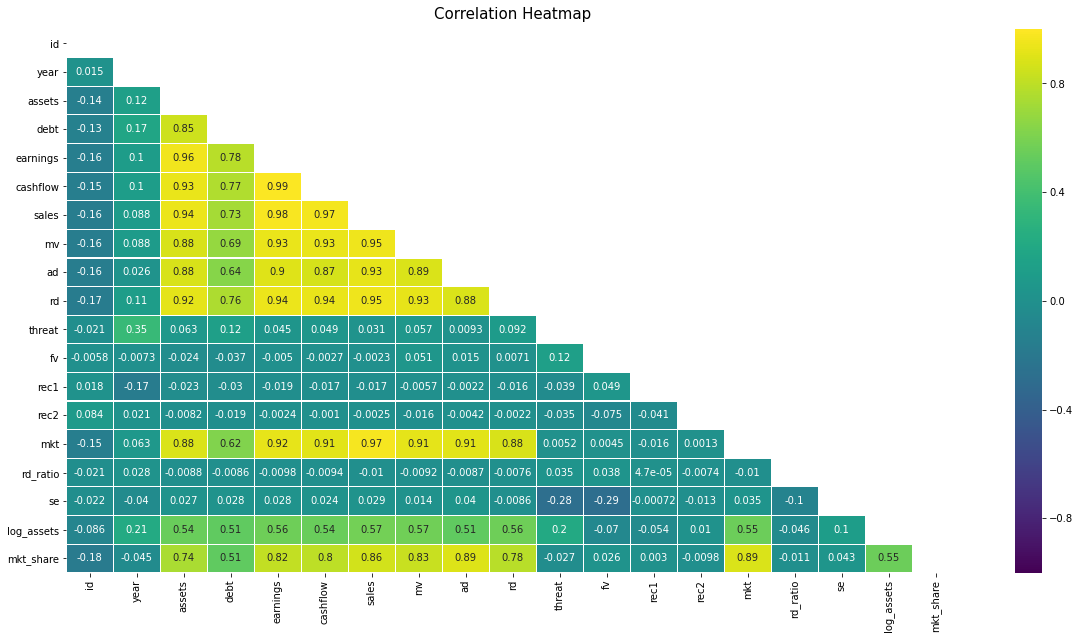

In [229]:
# Create a correlation matrix to check if it is necessary to use PCA.
corr_matrix = data.corr()

plt.figure(figsize=(20, 10))

mask = np.triu(np.ones_like(corr_matrix))
heatmap = sns.heatmap(corr_matrix, vmin=-1, annot=True, vmax=1, linewidths=0.1, center=0,cmap= 'viridis', mask=mask)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':15}, pad=10)

Based on the correlation matrix, we'll drop columns that are highly correlated (Degree of correlation > 0.7) to columns that we have chosen as independent variables. The following are the independent variables for the linear regression:
1. mkt_growth
2. mkt_share
3. log_assets
4. se
5. rec1
6. rec2
7. threat
8. debt
9. id
10. year

Additionally,
1. We drop the following because they have high correlation with **mkt_share**: `assets`, `earnings`, `cashflow`, `sales`, `mv`, `ad`, `rd`, `mkt`
2. Firm value will become the core depenent variable, therefore will not be part of features. Because it does not high correlation with any other variable, we need a lot of independent variables to explain it.

### Model Development – Regression
#### Data Preparation

In [238]:
#Encode categorical data into ordinal data to avoid affect the line of fit
### Therefore, unique companies and years will be mapped to a number from 0 to n, where n is the total number of unique companies/years
encoder = OrdinalEncoder()
data["id"] = encoder.fit_transform(data[['id']])
data["year"] = encoder.fit_transform(data[['year']])
data.tail()

,id,year,assets,debt,earnings,cashflow,sales,mv,ad,rd,threat,fv,rec1,rec2,mkt,rd_ratio,se,log_assets,mkt_share
22528,217.0,14.0,21.649,0.060,0.426,1.256,31.432,41.24855,0.062,2.275000,1.3064,1.259114,0,0,9.481000,0.072378,-0.102222,3.074959,0.013402
22531,523.0,14.0,327.165,0.727,16.362,-9.093,232.810,972.89484,0.300,34.304001,3.3160,2.329628,0,0,42.007000,0.147348,-0.103935,5.790465,0.099264
22544,523.0,15.0,295.932,0.594,-30.705,-36.164,204.589,123.91232,0.200,42.556999,3.0059,-0.203015,0,1,46.136002,0.208012,-0.143131,5.690130,0.084259
22562,523.0,16.0,270.251,0.456,-32.309,-0.960,164.031,210.36211,0.300,27.639000,2.5228,0.181554,0,0,45.980000,0.168499,-0.101162,5.599351,0.078155
22569,523.0,17.0,269.562,0.126,-28.638,-1.793,195.363,202.43436,0.500,33.529999,2.3966,0.250233,0,0,51.291000,0.171629,-0.122532,5.596798,0.084679


In [239]:
y = data["fv"] #Target variable
X = data.drop(["fv", "assets", "earnings", "cashflow", "sales", "mv", "ad", "rd", "mkt"], axis=1) #Independent variable
print(X.shape, y.shape)
X.head()

(3279, 10) (3279,)


,id,year,debt,threat,rec1,rec2,rd_ratio,se,log_assets,mkt_share
0,8.0,0.0,0.000,1.7482,0,0,0.084488,-0.056300,1.411718,0.003572
3,177.0,0.0,0.011,9.1024,0,0,0.380521,-0.162903,2.064582,0.005353
4,310.0,0.0,0.000,1.0658,0,0,0.008645,0.014166,3.198510,0.042573
19,302.0,0.0,0.929,1.0549,0,0,0.028223,-0.018478,1.792925,0.006906
23,45.0,0.0,7.213,1.0538,0,0,0.649202,-0.266398,2.868410,0.008063


In [240]:
#Standardize the data for principle component analysis
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(X_scaled.shape)

(3279, 10)


#### Dimensionality Reduction – PCA

In [241]:
# We now check the variance captured by PCA for different number of components.
for i in range(1, X_scaled.shape[1]):
    pca = PCA(n_components=i)
    pca.fit_transform(X_scaled)
    expl_var_ratio = pca.explained_variance_ratio_ 
    print('n. of components:', i, 'explained var. ratio:', expl_var_ratio.sum())
    if expl_var_ratio.sum() >= 0.95:
        break

n. of components: 1 explained var. ratio: 0.21851186776846365
n. of components: 2 explained var. ratio: 0.3685067887057621
n. of components: 3 explained var. ratio: 0.4822683739401467
n. of components: 4 explained var. ratio: 0.5850695042879023
n. of components: 5 explained var. ratio: 0.6840368664582188
n. of components: 6 explained var. ratio: 0.7745888010877988
n. of components: 7 explained var. ratio: 0.858486448386467
n. of components: 8 explained var. ratio: 0.9163070432534061
n. of components: 9 explained var. ratio: 0.964016428891509


We run principal component annalysis to determine how many variables can explain 95% iof the variance. from the output, we need at least 9 indpendent variables to explain the variance of the data to a degree above 95%. Because we only have 11 features, we do not have to drop the final two as it will not affect our model performance significantly. 

### Simple Modeling
Linear Regression and Regularised Linear Regression

In [242]:
#Train Test Split: Reserve 20% of data for final model testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=20)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2623, 10) (656, 10) (2623,) (656,)


In [243]:
#Linear Regression
reg = LinearRegression()
scores = cross_val_score(reg, X_train, y_train, cv=10, scoring="neg_mean_squared_error")
print(scores, scores.mean())

[ -4.25857333  -4.35955643  -3.27544007  -5.75176755  -4.04995902
 -14.03097345  -6.94427555  -4.31184821  -5.800961   -11.88828909] -6.467164370085233


In [244]:
#Regularised Regression (L1) – Lasso
reg = Lasso(alpha=1)
scores = cross_val_score(reg, X_train, y_train, cv=10, scoring="neg_mean_squared_error")
print(scores, scores.mean())

[ -4.94630316  -5.16328508  -3.62663954  -6.68335127  -4.60826089
 -15.18945021  -6.64789591  -4.35585986  -6.20065027 -12.28331053] -6.970500671324513


In [245]:
#Regularised Regression (L2) – Ridge
reg = Ridge(alpha=1)
scores = cross_val_score(reg, X_train, y_train, cv=10, scoring="neg_mean_squared_error")
print(scores, scores.mean())

[ -4.26482595  -4.34170455  -3.27442588  -5.75724873  -4.05089382
 -14.04342495  -6.93600257  -4.30502562  -5.80148645 -11.88336605] -6.465840456378212


In [246]:
#Regularised Regression (L1 & L2) – Elastic Net
reg = ElasticNet(alpha=1, l1_ratio=0.05)
scores = cross_val_score(reg, X_train, y_train, cv=10, scoring="neg_mean_squared_error")
print(scores, scores.mean())

[ -4.81282771  -5.20737716  -3.52525008  -6.4608055   -4.44708124
 -15.01230786  -6.7435076   -4.29689871  -6.10832128 -12.08399764] -6.869837478674347


#### Outputing Coefficients for the best performing models
##### Linear Regression Final

In [247]:
#Find mean square error from the Test Dataset
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
print("Mean Square Error", mean_squared_error(y_test, y_pred))

Mean Square Error 7.944588303566629


In [248]:
#Here are the coefficients from the Linear Regression
reg = LinearRegression().fit(X, y) #Fit final regression with all data available

coefficients_dict = dict()
for i in range(len(X.columns)):
    coefficients_dict[X.columns[i]] = reg.coef_[i]

print(coefficients_dict)

{'id': -5.93357110537886e-05, 'year': -0.0008251317857916554, 'debt': -3.4915839781525623e-05, 'threat': 0.01831808355992104, 'rec1': 0.616572377541668, 'rec2': -0.9438711170387711, 'rd_ratio': 0.0017822987224218496, 'se': -4.746323973882026, 'log_assets': -0.11586771932592096, 'mkt_share': 0.09205086096717645}


##### Ridge RegressioN Final

In [249]:
## Ridge Regression
#Find mean square error from the Test Dataset
reg = Ridge(alpha=1).fit(X_train, y_train)
y_pred = reg.predict(X_test)
print("Mean Square Error", mean_squared_error(y_test, y_pred))

Mean Square Error 7.956122518938833


In [250]:
#Here are the coefficients from the Ridge Regularised Regression
reg = Ridge(alpha=1).fit(X, y) #Fit final regression with all data available

coefficients_dict = dict()
for i in range(len(X.columns)):
    coefficients_dict[X.columns[i]] = reg.coef_[i]

print(coefficients_dict)

{'id': -5.831554376500236e-05, 'year': -0.0009054098234161513, 'debt': -3.4888504801404855e-05, 'threat': 0.018648533885334242, 'rec1': 0.6110160183515663, 'rec2': -0.9360086781599918, 'rd_ratio': 0.001910161850890696, 'se': -4.673664371683657, 'log_assets': -0.11690491760494663, 'mkt_share': 0.0922988906576291}
